<a href="https://colab.research.google.com/github/raviakasapu/LLM-Training-Docs/blob/main/Fine_Tuning_Alpaca_and_LLaMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fine Tuning Alpaca and LLaMA

https://www.mlexpert.io/machine-learning/tutorials/alpaca-fine-tuning

In [ ]:
!pip install -U pip
!pip install accelerate==0.18.0
!pip install appdirs==1.4.4
#!pip install bitsandbytes==0.37.2
!pip install bitsandbytes
!pip install datasets==2.10.1
!pip install fire==0.5.0
!pip install git+https://github.com/huggingface/peft.git
!pip install git+https://github.com/huggingface/transformers.git
!pip install torch==2.0.0
!pip install sentencepiece==0.1.97
!pip install tensorboardX==2.6
!pip install gradio==3.23.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116933 sha256=1a5a4005168642d

In [10]:
import transformers
import textwrap
from transformers import LlamaTokenizer, LlamaForCausalLM
import os
import sys
from typing import List

from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_int8_training,
)

import fire
import torch
from datasets import load_dataset
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import rcParams

%matplotlib inline
sns.set(rc={'figure.figsize':(10, 7)})
sns.set(rc={'figure.dpi':100})
sns.set(style='white', palette='muted', font_scale=1.2)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [3]:
!gdown 1xQ89cpZCnafsW5T3G3ZQWvR7q682t2BN

Downloading...
From: https://drive.google.com/uc?id=1xQ89cpZCnafsW5T3G3ZQWvR7q682t2BN
To: /content/bitcoin-sentiment-tweets.csv
100% 242k/242k [00:00<00:00, 81.0MB/s]


In [4]:
df = pd.read_csv("bitcoin-sentiment-tweets.csv")
df.head()

,date,tweet,sentiment
0,Fri Mar 23 00:40:40 +0000 2018,@p0nd3ea Bitcoin wasn't built to live on excha...,1.0
1,Fri Mar 23 00:40:40 +0000 2018,@historyinflicks Buddy if I had whatever serie...,1.0
2,Fri Mar 23 00:40:42 +0000 2018,@eatBCH @Bitcoin @signalapp @myWickr @Samsung ...,0.0
3,Fri Mar 23 00:41:04 +0000 2018,@aantonop Even if Bitcoin crash tomorrow morni...,0.0
4,Fri Mar 23 00:41:07 +0000 2018,I am experimenting whether I can live only wit...,1.0


In [5]:
df.sentiment.value_counts()

 0.0    860
 1.0    779
-1.0    258
Name: sentiment, dtype: int64

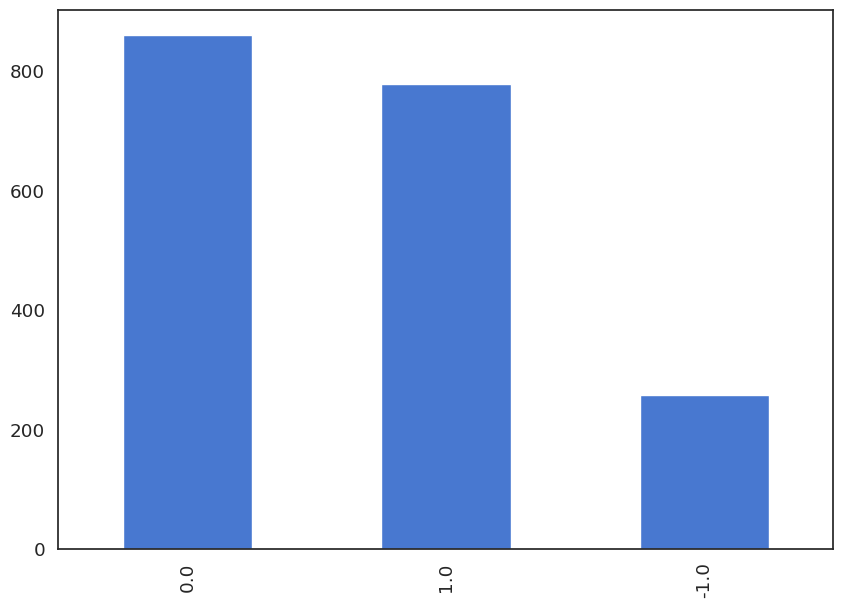

In [6]:
df.sentiment.value_counts().plot(kind='bar');

In [7]:
def sentiment_score_to_name(score: float):
    if score > 0:
        return "Positive"
    elif score < 0:
        return "Negative"
    return "Neutral"

dataset_data = [
    {
        "instruction": "Detect the sentiment of the tweet.",
        "input": row_dict["tweet"],
        "output": sentiment_score_to_name(row_dict["sentiment"])
    }
    for row_dict in df.to_dict(orient="records")
]

dataset_data[0]

{'instruction': 'Detect the sentiment of the tweet.',
 'input': "@p0nd3ea Bitcoin wasn't built to live on exchanges.",
 'output': 'Positive'}

In [8]:
import json
with open("alpaca-bitcoin-sentiment-dataset.json", "w") as f:
   json.dump(dataset_data, f)

In [9]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.ca

In [10]:
BASE_MODEL = "meta-llama/Llama-2-7b-chat-hf"

model = LlamaForCausalLM.from_pretrained(
    BASE_MODEL,
    load_in_8bit=True,
    torch_dtype=torch.float16,
    device_map="auto",
)

tokenizer = LlamaTokenizer.from_pretrained(BASE_MODEL)

tokenizer.pad_token_id = (
    0  # unk. we want this to be different from the eos token
)
tokenizer.padding_side = "left"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
data = load_dataset("json", data_files="alpaca-bitcoin-sentiment-dataset.json")
data["train"]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-0e279d42baef176a/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 1897
})

In [12]:
def generate_prompt(data_point):
    return f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.  # noqa: E501
### Instruction:
{data_point["instruction"]}
### Input:
{data_point["input"]}
### Response:
{data_point["output"]}"""



In [13]:
CUTOFF_LEN = 256

In [14]:

def tokenize(prompt, add_eos_token=True):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=CUTOFF_LEN,
        padding=False,
        return_tensors=None,
    )
    if (
        result["input_ids"][-1] != tokenizer.eos_token_id
        and len(result["input_ids"]) < CUTOFF_LEN
        and add_eos_token
    ):
        result["input_ids"].append(tokenizer.eos_token_id)
        result["attention_mask"].append(1)

    result["labels"] = result["input_ids"].copy()

    return result



In [15]:
def generate_and_tokenize_prompt(data_point):
    full_prompt = generate_prompt(data_point)
    tokenized_full_prompt = tokenize(full_prompt)
    return tokenized_full_prompt

In [16]:
train_val = data["train"].train_test_split(
    test_size=200, shuffle=True, seed=42
)

train_data = (
    train_val["train"].map(generate_and_tokenize_prompt)
)

val_data = (
    train_val["test"].map(generate_and_tokenize_prompt)
)

Map:   0%|          | 0/1697 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [17]:
train_data

Dataset({
    features: ['instruction', 'input', 'output', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1697
})

In [18]:
LORA_R = 8
LORA_ALPHA = 16
LORA_DROPOUT= 0.05
LORA_TARGET_MODULES = [
    "q_proj",
    "v_proj",
]

BATCH_SIZE = 128
MICRO_BATCH_SIZE = 4
GRADIENT_ACCUMULATION_STEPS = BATCH_SIZE // MICRO_BATCH_SIZE
LEARNING_RATE = 3e-4
TRAIN_STEPS = 30
OUTPUT_DIR = "experiments"

In [19]:
model = prepare_model_for_int8_training(model)
config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=LORA_TARGET_MODULES,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, config)
model.print_trainable_parameters()

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:136: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


trainable params: 4,194,304 || all params: 6,742,609,920 || trainable%: 0.06220594176090199


In [20]:
training_arguments = transformers.TrainingArguments(
    per_device_train_batch_size=MICRO_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    warmup_steps=100,
    max_steps=TRAIN_STEPS,
    learning_rate=LEARNING_RATE,
    fp16=True,
    logging_steps=10,
    optim="adamw_torch",
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=50,
    save_steps=50,
    output_dir=OUTPUT_DIR,
    save_total_limit=3,
    load_best_model_at_end=True,
    report_to="tensorboard"
)

In [21]:
data_collator = transformers.DataCollatorForSeq2Seq(
    tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
)

In [22]:
trainer = transformers.Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    args=training_arguments,
    data_collator=data_collator
)


In [23]:
model.config.use_cache = False
old_state_dict = model.state_dict


In [24]:
model.state_dict = (
    lambda self, *_, **__: get_peft_model_state_dict(
        self, old_state_dict()
    )
).__get__(model, type(model))



In [25]:
model = torch.compile(model)


In [26]:
#trainer.train()

/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:298: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss,Validation Loss


TrainOutput(global_step=30, training_loss=2.9559658050537108, metrics={'train_runtime': 3539.7699, 'train_samples_per_second': 1.085, 'train_steps_per_second': 0.008, 'total_flos': 2.073812008599552e+16, 'train_loss': 2.9559658050537108, 'epoch': 2.26})

In [28]:
model.save_pretrained(OUTPUT_DIR)

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [7]:
!huggingface-cli login
model.push_to_hub("ravi259/alpaca-bitcoin-tweets-sentiment", use_auth_token=True)


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.c

NameError: ignored

In [2]:
!git clone https://github.com/tloen/alpaca-lora.git
%cd alpaca-lora
!git checkout a48d947

fatal: destination path 'alpaca-lora' already exists and is not an empty directory.
/content/alpaca-lora
HEAD is now at a48d947 把中文LoRA放在一起


In [3]:
!git clone https://github.com/timdettmers/bitsandbytes.git


fatal: destination path 'bitsandbytes' already exists and is not an empty directory.


In [4]:
!pip install bitsandbytes --upgrade

In [12]:
!pip install fire --upgrade

In [13]:
!python generate.py \
    --load_8bit \
    --base_model 'meta-llama/Llama-2-7b-chat-hf' \
    --lora_weights 'ravi259/alpaca-bitcoin-tweets-sentiment' \
    --share_gradio

Loading checkpoint shards: 100% 2/2 [01:02<00:00, 31.14s/it]
Traceback (most recent call last):
  File "/content/alpaca-lora/generate.py", line 189, in <module>
    fire.Fire(main)
  File "/usr/local/lib/python3.10/dist-packages/fire/core.py", line 141, in Fire
    component_trace = _Fire(component, args, parsed_flag_args, context, name)
  File "/usr/local/lib/python3.10/dist-packages/fire/core.py", line 475, in _Fire
    component, remaining_args = _CallAndUpdateTrace(
  File "/usr/local/lib/python3.10/dist-packages/fire/core.py", line 691, in _CallAndUpdateTrace
    component = fn(*varargs, **kwargs)
  File "/content/alpaca-lora/generate.py", line 40, in main
    model = PeftModel.from_pretrained(
  File "/usr/local/lib/python3.10/dist-packages/peft/peft_model.py", line 332, in from_pretrained
    model.load_adapter(model_id, adapter_name, is_trainable=is_trainable, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/peft/peft_model.py", line 629, in load_adapter
    adapters_w